In [24]:
import glob
import xarray as xr
import os
import numpy as np
import warnings
import sys
import pickle
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/disk/p/jkcm/Code')
from Lagrangian_CSET.CSET_data_classes import CSET_Flight
from Lagrangian_CSET import utils
from Lagrangian_CSET import met_utils as mu
from Lagrangian_CSET.LoopTimer import LoopTimer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
scene_dict = {-1: 'NC',
              0: 'open',
              1: 'closed',
              2: 'homogen',
              3: 'disorg',
              4: 'too clear'}


def get_GOES_cloud_fraction(lat, lon, time, degrees):
    """
    Get the GOES cloud fraction value from to the space/time, filtering for high cloud. Use GOES flight files
    """
    variable_list = ['cloud_phase', 'cloud_top_height', 'cloud_top_temperature']
    data = utils.get_GOES_data(variable_list, lat=lat, lon=lon, time=time, degree=degrees)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warm_low_cloud = (
                        (data['cloud_phase'] == 1) &
                        (data['cloud_top_height'] < 4.) &
                        (data['cloud_top_temperature'] > 273.15))
        warm_low_cloud_fraction = np.sum(warm_low_cloud) /\
                                float(np.sum((data['cloud_phase'] == 4) | warm_low_cloud))
    return warm_low_cloud_fraction

In [3]:
data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
with open(os.path.join(data_loc, 'locs_by_scene.pickle'), 'rb') as f:
        locs_by_scene = pickle.load(f)

In [22]:
cf_by_scene = {}

for scene, locs in locs_by_scene.items():
    cfs = []
    for loc in locs:
        cf = get_GOES_cloud_fraction(loc[0], loc[1], loc[2], degrees=1)
        cfs.append(cf)
    cf_by_scene[scene] = cfs

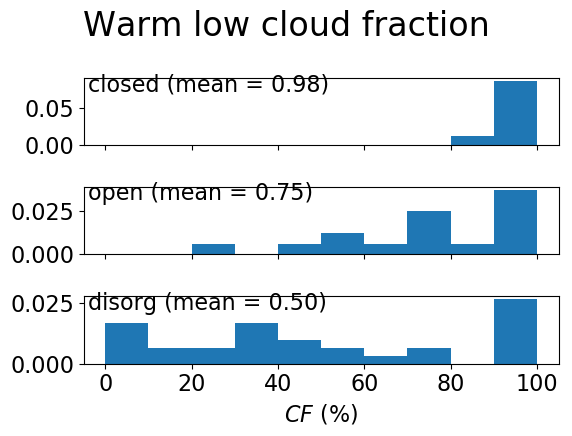

In [23]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for axi, scene in zip(ax, [1,0,3]):
    cfs = cf_by_scene[scene]
    axi.hist(np.array(cfs)[~np.isnan(cfs)]*100, bins = np.linspace(0,100,11), density=True)
    axi.annotate('{} (mean = {:0.2f})'.format(str(scene_dict[scene]), np.nanmean(cfs)), xy=(0.01, 0.8), xycoords='axes fraction')
ax[2].set_xlabel(r"$CF$ (%)")
plt.suptitle(r"Warm low cloud fraction", y=1.1)
fig.tight_layout()

fig.savefig("/home/disk/p/jkcm/plots/agu/cloudfrac_pdf.png", dpi=600, bbox_inches='tight')


In [26]:
data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
with open(os.path.join(data_loc, 'nep_scenes.pickle'), 'rb') as f:
        nep_scenes = pickle.load(f)

In [29]:
cfs_nep = nep_scenes['cf_nep']
scenes_nep = nep_scenes['scenes_nep']

In [32]:
cf_by_scene = {-1: [],
                 0: [],
                 1: [],
                 2: [],
                 3: [],
                 4: []}
for cf, scene in zip(cfs_nep, scenes_nep):
    if scene in cf_by_scene.keys():
        if cf > 0:
            cf_by_scene[scene].append(cf)

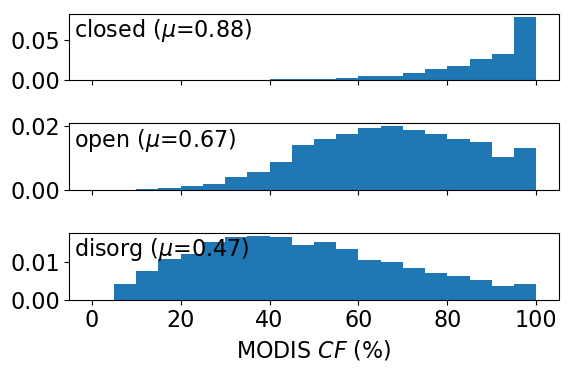

In [46]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,4))

for axi, scene in zip(ax, [1,0,3]):
    cfs = cf_by_scene[scene]
    axi.hist(np.array(cfs)[~np.isnan(cfs)]*100, bins = np.linspace(0,100,21), density=True)
    axi.annotate('{} ($\mu$={:0.2f})'.format(str(scene_dict[scene]), np.nanmean(cfs)), xy=(0.01, 0.95), xycoords='axes fraction', 
                 verticalalignment='top', horizontalalignment='left', fontsize=16)
ax[2].set_xlabel(r"MODIS $CF$ (%)")
# plt.suptitle(r"MODIS cloud fraction", y=1.1)
fig.tight_layout()

fig.savefig("/home/disk/user_www/jkcm/misc/agu/modis_cloudfrac_pdf.png", dpi=600, bbox_inches='tight')